<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/5_2_Curado_de_bases_de_datos_versi%C3%B3n2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python script based on: Sánchez-Cruz N, Pilón-Jiménez BA and Medina-Franco JL. Functional group and diversity analysis of BIOFACQUIM: A Mexican natural product database. F1000Research 2020, 8(Chem Inf Sci):2071 DOI:[10.12688/f1000research.21540](https://doi.org/10.12688/f1000research.21540.2).                                                                        [GitHub](https://github.com/DIFACQUIM/IFG_General/blob/master/Compounds_Curation.py)  

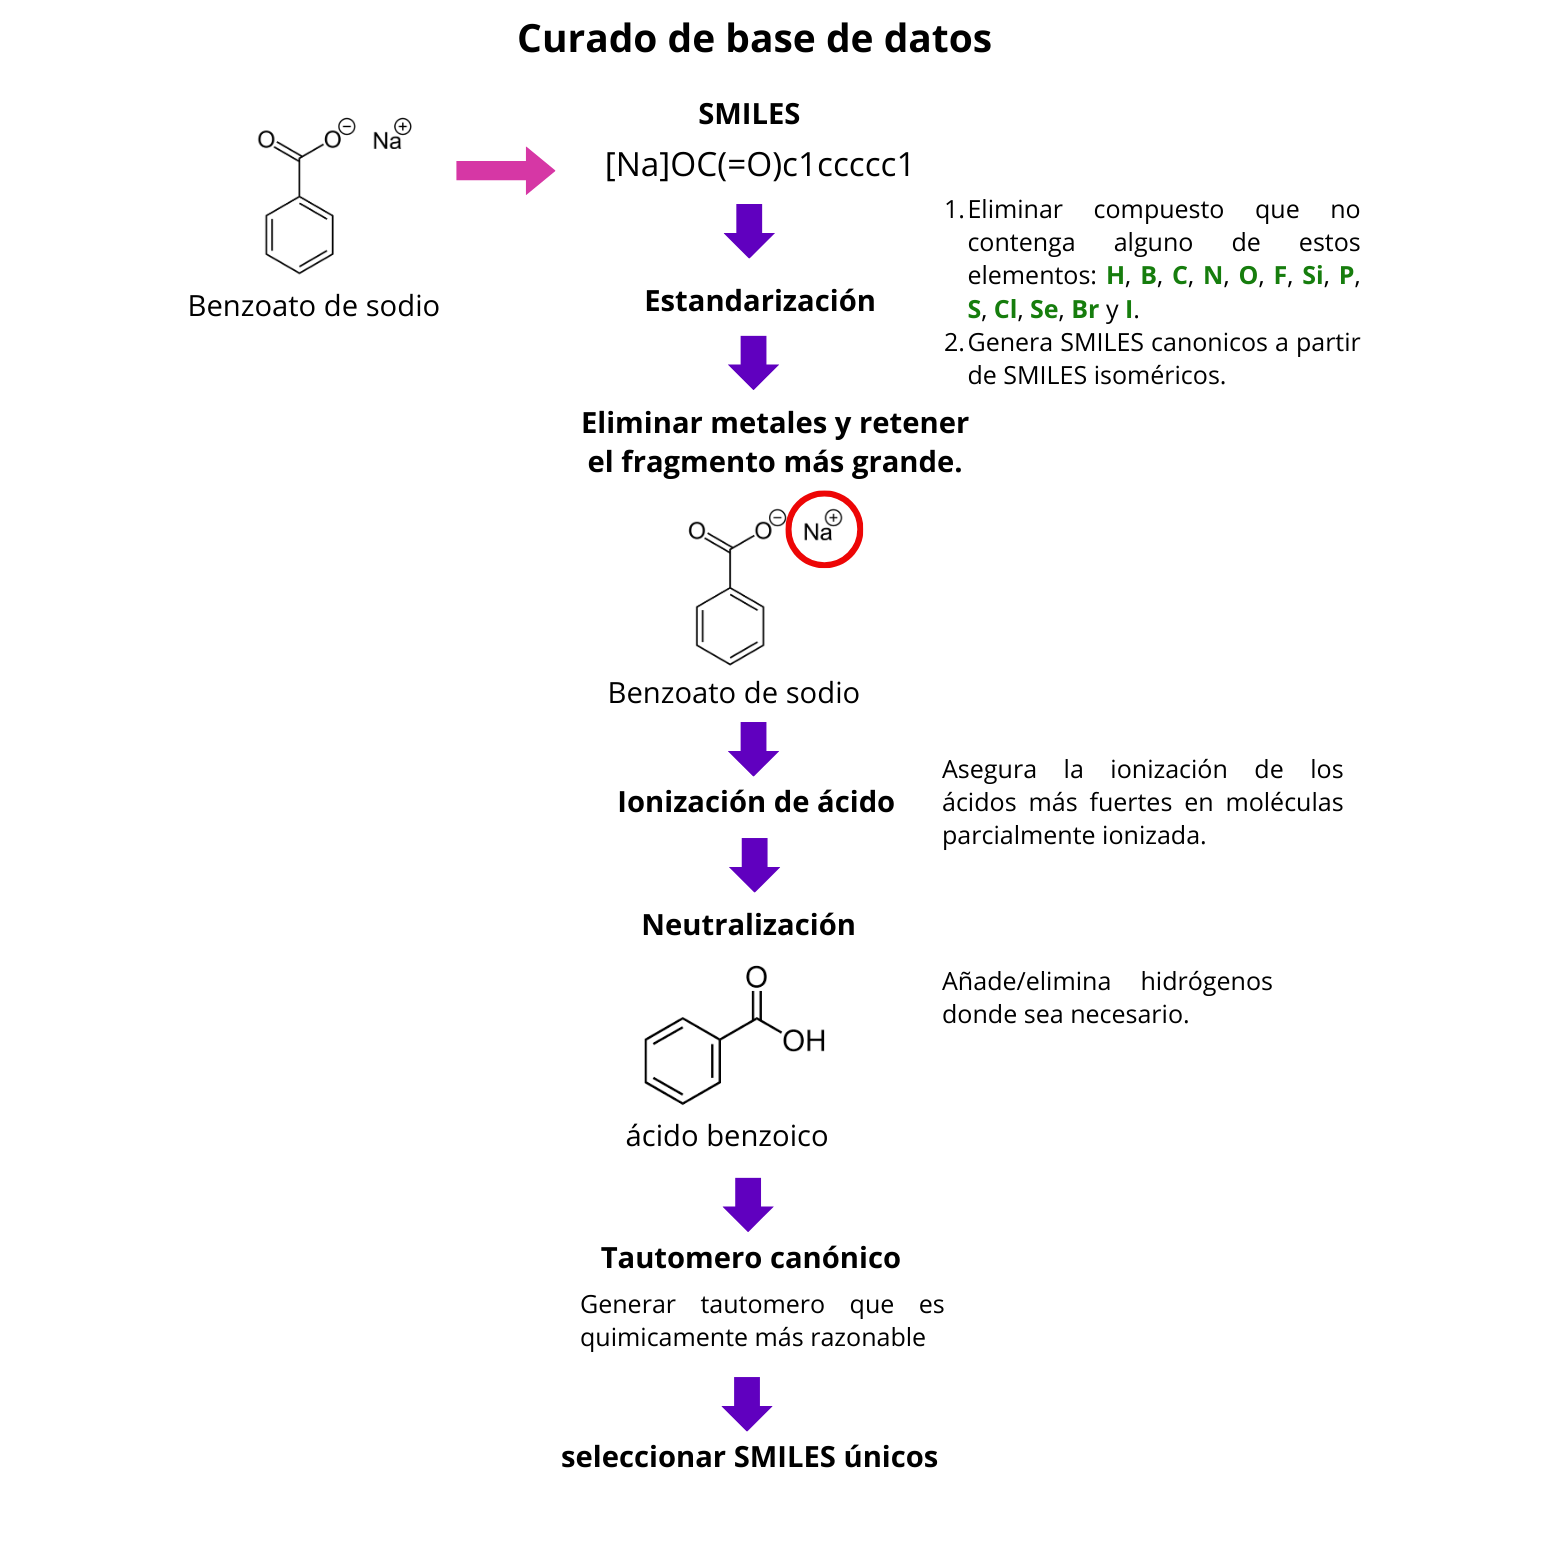

#Preparación del entorno

In [1]:
#Instalar RDKit
!pip install -q rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.5 MB/s eta 0:00:00


In [2]:
#Instalar MolVS
!pip install -q molvs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
#Importar librerías necesarias
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from molvs.standardize import Standardizer
from molvs.charge import Uncharger, Reionizer
from molvs.fragment import LargestFragmentChooser
from molvs.tautomer import TautomerCanonicalizer
from rdkit.Chem.rdmolops import GetFormalCharge, RemoveStereochemistry

#Base de datos

In [4]:
#Cargar base de datos
url ="https://github.com/DIFACQUIM/Cursos/raw/main/Datasets/chembl_search_output_xlsx.xlsx"
df = pd.read_excel(url, index_col=0)  #Archivo formato excel
df.head(2) # Muestra las dos primeras filas de información, para verificar que cargó la información correctamente

,first_approval,indication_class,max_phase,molecule_chembl_id,molecule_properties,molecule_structures,molecule_type,oral,parenteral,pref_name,...,document_chembl_id,document_journal,ligand_efficiency,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,units,value
0,1986.0,Inhibitor (beta-lactamase); Synergist (penicil...,4.0,CHEMBL403,"{'alogp': '-0.79', 'aromatic_rings': 0, 'cx_lo...",{'canonical_smiles': 'CC1(C)[C@H](C(=O)O)N2C(=...,Small molecule,False,True,SULBACTAM,...,CHEMBL5154912,J Med Chem,NaN,nM,50000.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,uM,50.0
1,1950.0,Antibacterial,4.0,CHEMBL421,"{'alogp': '3.70', 'aromatic_rings': 3, 'cx_log...",{'canonical_smiles': 'O=C(O)c1cc(/N=N/c2ccc(S(...,Small molecule,True,False,SULFASALAZINE,...,CHEMBL4392846,Bioorg Med Chem,"{'bei': '12.85', 'le': '0.25', 'lle': '1.42', ...",nM,7600.0,CHEMBL4295557,Middle East respiratory syndrome-related coron...,Replicase polyprotein 1ab,uM,7.6


In [5]:
#Imprimir columnas del dataframe
print(df.columns)

Index(['first_approval', 'indication_class', 'max_phase', 'molecule_chembl_id',
       'molecule_properties', 'molecule_structures', 'molecule_type', 'oral',
       'parenteral', 'pref_name', 'topical', 'canonical_smiles', 'activity_id',
       'assay_chembl_id', 'assay_description', 'document_chembl_id',
       'document_journal', 'ligand_efficiency', 'standard_units',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'units', 'value'],
      dtype='object')


In [6]:
#Seleccionar columnas de interés
data = df[['first_approval', 'indication_class', 'max_phase', 'molecule_chembl_id', 'oral', 'parenteral', 'topical',
               'pref_name', 'canonical_smiles', 'target_chembl_id', 'target_organism']]
data

,first_approval,indication_class,max_phase,molecule_chembl_id,oral,parenteral,topical,pref_name,canonical_smiles,target_chembl_id,target_organism
0,1986.0,Inhibitor (beta-lactamase); Synergist (penicil...,4.0,CHEMBL403,False,True,False,SULBACTAM,CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2
1,1950.0,Antibacterial,4.0,CHEMBL421,True,False,False,SULFASALAZINE,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...,CHEMBL4295557,Middle East respiratory syndrome-related coron...
2,1945.0,Antibacterial,4.0,CHEMBL437,False,False,True,SULFATHIAZOLE,Nc1ccc(S(=O)(=O)Nc2nccs2)cc1,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2
3,NaN,NaN,3.0,CHEMBL50,False,False,False,QUERCETIN,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,CHEMBL5118,SARS coronavirus
4,1949.0,"Anti-Amebic; Antimalarial,Anti-Amebic; Suppres...",4.0,CHEMBL76,True,True,False,CHLOROQUINE,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CHEMBL4662936,Severe acute respiratory syndrome coronavirus 2
5,1982.0,"Anti-Amebic; Anti-Infective, Topical",4.0,CHEMBL497,False,False,True,CLIOQUINOL,Oc1c(I)cc(Cl)c2cccnc12,CHEMBL4662936,Severe acute respiratory syndrome coronavirus 2
6,1980.0,Anti-Inflammatory,4.0,CHEMBL509,True,False,False,MECLOFENAMIC ACID,Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl,CHEMBL3927,SARS coronavirus
7,1958.0,Antibacterial,4.0,CHEMBL615,True,False,False,PENICILLIN V,CC1(C)S[C@@H]2[C@H](NC(=O)COc3ccccc3)C(=O)N2[C...,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2
8,1966.0,Antineoplastic,4.0,CHEMBL727,True,False,False,THIOGUANINE,Nc1nc2[nH]cnc2c(=S)[nH]1,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2
9,2000.0,NaN,4.0,CHEMBL729,True,False,False,LOPINAVIR,Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2


In [7]:
#Cambiar nombre de columnas
data.columns = ['First Approval', 'Indication', 'Max Phase', 'Molecule ChEMBL ID', 'Oral', 'Parenteral', 'Topical',
              'Name', 'Smiles', 'Target ChEMBL ID', 'Organism']

In [8]:
data.tail(2) #Ver últimas dos filas de datos

,First Approval,Indication,Max Phase,Molecule ChEMBL ID,Oral,Parenteral,Topical,Name,Smiles,Target ChEMBL ID,Organism
27,2020.0,NaN,4.0,CHEMBL4065616,False,True,False,REMDESIVIR,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@@]...,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2
28,NaN,NaN,3.0,CHEMBL4802135,False,False,False,NIRMATRELVIR,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,CHEMBL4888440,Human coronavirus 229E


In [9]:
#Información del número de filas y columnas
data.shape

(29, 11)

#Funciones MolVS

In [10]:
#Definir funciones
STD = Standardizer() # Get the standardized version of a given SMILES string (canonical SMILES).
LFC = LargestFragmentChooser() # Select the largest fragment from a salt (ionic compound).
UC = Uncharger() # Charge corrections are applied to ensure, for example, that free metals are correctly ionized.
RI = Reionizer() # Neutralize molecule by adding/removing hydrogens.
TC = TautomerCanonicalizer()  # Return a tautormer “reasonable” from a chemist’s point, but isn’t guaranteed to be the most energetically favourable.

##*Standardizer*

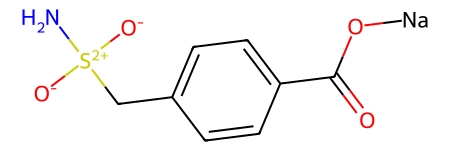

In [11]:
mol = Chem.MolFromSmiles('N[S++]([O-])([O-])Cc1ccc(cc1)C(=O)O[Na]')
mol

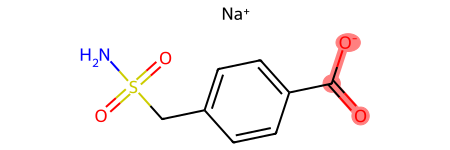

In [12]:
smol = STD(mol)
smol

##*Largest Fragment Chooser*

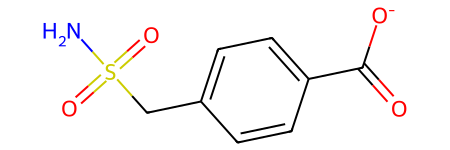

In [13]:
lmol = LFC(smol)
lmol

##*Uncharger*

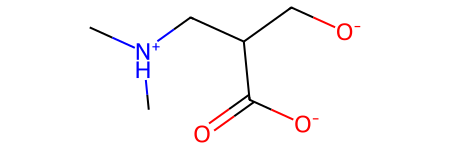

In [14]:
mol2 = Chem.MolFromSmiles('[O-]CC(C(=O)[O-])C[NH+](C)C')
mol2

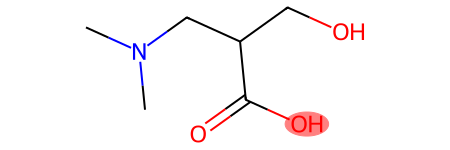

In [15]:
umol2 = UC(mol2)
umol2

##*Reionizer*

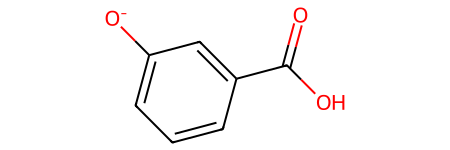

In [16]:
mol3 = Chem.MolFromSmiles('c1ccc([O-])cc1C(=O)O')
mol3

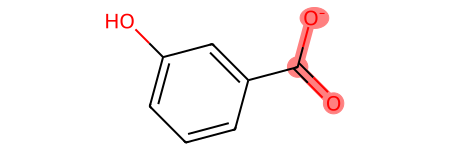

In [17]:
rmol3 = RI(mol3)
rmol3

##*Tautomer Canonicalizer*

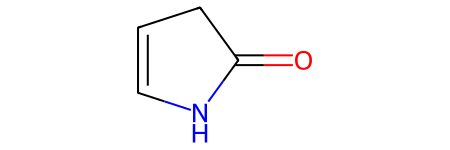

In [18]:
mol4 = Chem.MolFromSmiles('O=C1CC=CN1')
mol4

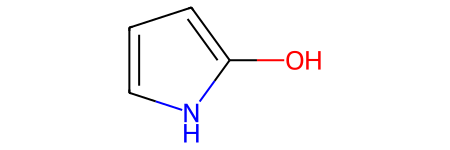

In [19]:
tmol4 = TC(mol4)
tmol4

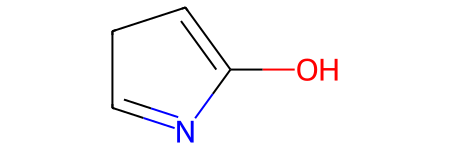

In [20]:
mol5 = Chem.MolFromSmiles('OC1=CCC=N1')
mol5

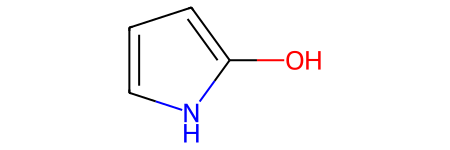

In [21]:
tmol5 = TC(mol5)
tmol5

#Curado de toda la base de datos

In [22]:
#Función para curado
def pretreatment(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol == None:
            #If rdkit could not parse the smiles, returns Error 1
            return "Error 1"
        else:
            mol = STD(mol)
            mol = LFC(mol)

            allowed_elements = {"H","B","C","N","O","F","Si","P","S","Cl","Se","Br","I"}
            actual_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            if len(actual_elements-allowed_elements) == 0:
                mol = UC(mol)
                mol = RI(mol)
                #RemoveStereochemistry(mol)
                mol = TC(mol)
                return Chem.MolToSmiles(mol)
            else:
                # If molecule contains other than the allowed elements, return "Error 2"
                return "Error 2"
    except:
        return "Something else was found"

In [23]:
#Nueva columna de SMILES
data["NEW_SMILES"] = [pretreatment(x) for x in data["Smiles"]]
data.head()

<ipython-input-23-98d53b2ec18e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["NEW_SMILES"] = [pretreatment(x) for x in data["Smiles"]]


,First Approval,Indication,Max Phase,Molecule ChEMBL ID,Oral,Parenteral,Topical,Name,Smiles,Target ChEMBL ID,Organism,NEW_SMILES
0,1986.0,Inhibitor (beta-lactamase); Synergist (penicil...,4.0,CHEMBL403,False,True,False,SULBACTAM,CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,CC1(C)C(C(=O)O)N2C(=O)C[C@H]2S1(=O)=O
1,1950.0,Antibacterial,4.0,CHEMBL421,True,False,False,SULFASALAZINE,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...,CHEMBL4295557,Middle East respiratory syndrome-related coron...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)N=c3cccc[nH]3)cc2...
2,1945.0,Antibacterial,4.0,CHEMBL437,False,False,True,SULFATHIAZOLE,Nc1ccc(S(=O)(=O)Nc2nccs2)cc1,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,Nc1ccc(S(=O)(=O)N=c2[nH]ccs2)cc1
3,NaN,NaN,3.0,CHEMBL50,False,False,False,QUERCETIN,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,CHEMBL5118,SARS coronavirus,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12
4,1949.0,"Anti-Amebic; Antimalarial,Anti-Amebic; Suppres...",4.0,CHEMBL76,True,True,False,CHLOROQUINE,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CHEMBL4662936,Severe acute respiratory syndrome coronavirus 2,CCN(CC)CCCC(C)N=c1cc[nH]c2cc(Cl)ccc12


In [24]:
# Eliminar smiles no leído por RDKit
data = data[data["NEW_SMILES"] != "Error 1"]
# Eliminar smiles que contiene átomos no permitidos
data = data[data["NEW_SMILES"] != "Error 2"]
# Eliminar otros errores
data = data[data["NEW_SMILES"] != "Something else was found"].reset_index(drop=True)

In [25]:
# Eliminar duplicados
data = data.drop_duplicates(subset=["NEW_SMILES"], keep="first").reset_index(drop=True)
print(data.shape)
data.head(2)

(29, 12)


,First Approval,Indication,Max Phase,Molecule ChEMBL ID,Oral,Parenteral,Topical,Name,Smiles,Target ChEMBL ID,Organism,NEW_SMILES
0,1986.0,Inhibitor (beta-lactamase); Synergist (penicil...,4.0,CHEMBL403,False,True,False,SULBACTAM,CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,CC1(C)C(C(=O)O)N2C(=O)C[C@H]2S1(=O)=O
1,1950.0,Antibacterial,4.0,CHEMBL421,True,False,False,SULFASALAZINE,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...,CHEMBL4295557,Middle East respiratory syndrome-related coron...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)N=c3cccc[nH]3)cc2...


In [26]:
# Guardar dataframe como archivo csv
data.to_csv("chembl_search_output_curada.csv", sep=",", index=False)

##Para saber más:

[*Pre-Processing Molecules*](https://portal.valencelabs.com/datamol/post/solving-for-complex-onboarding-paving-a-path-to-value-for-your-customers-zw1rSUlpxArKiiu)

[MolStandardize](https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb)

[Combining IC50 or Ki Values from Different Sources Is a Source of Significant Noise](https://pubs.acs.org/doi/10.1021/acs.jcim.4c00049?s=08)